In [1]:
#Import the necessary libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score


from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
df = pd.read_csv('Scraped_dataset.csv')
df.head(3)

,Date of Booking,Date of Journey,Airline-Class,Departure Time,Arrival Time,Duration,Total Stops,Price
0,15/01/2023,16/01/2023,SpiceJet \nSG-8169\nECONOMY,20:00\nDelhi,22:05\nMumbai,02h 05m,non-stop,"5,335"
1,15/01/2023,16/01/2023,Indigo \n6E-2519\nECONOMY,23:00\nDelhi,01:20\nMumbai,02h 20m,non-stop,"5,899"
2,15/01/2023,16/01/2023,GO FIRST \nG8- 354\nECONOMY,22:30\nDelhi,00:40\nMumbai,02h 10m,non-stop,"5,801"


In [3]:
df.shape

(452088, 8)

In [4]:
df.info

<bound method DataFrame.info of        Date of Booking Date of Journey                Airline-Class  \
0           15/01/2023      16/01/2023  SpiceJet \nSG-8169\nECONOMY   
1           15/01/2023      16/01/2023    Indigo \n6E-2519\nECONOMY   
2           15/01/2023      16/01/2023  GO FIRST \nG8- 354\nECONOMY   
3           15/01/2023      16/01/2023  SpiceJet \nSG-8709\nECONOMY   
4           15/01/2023      16/01/2023  Air India \nAI-805\nECONOMY   
...                ...             ...                          ...   
452083      15/01/2023      06/03/2023   Vistara \nUK-926\nBUSINESS   
452084      15/01/2023      06/03/2023   Vistara \nUK-918\nBUSINESS   
452085      15/01/2023      06/03/2023   Vistara \nUK-918\nBUSINESS   
452086      15/01/2023      06/03/2023   Vistara \nUK-946\nBUSINESS   
452087      15/01/2023      06/03/2023   Vistara \nUK-946\nBUSINESS   

          Departure Time    Arrival Time Duration Total Stops   Price  
0           20:00\nDelhi   22:05\nMumbai  0

In [5]:
df[["Airline","Flight_Code","Class"]] = df["Airline-Class"].str.split('\n',expand=True)
#Split the Departure Time column 

df[["Departure","Source"]] = df["Departure Time"].str.split('\n',expand=True)
#Split the Arrival Time column

df[["Arrival","Destination"]] = df["Arrival Time"].str.split('\n',expand=True)
#Convert Date columns into datetime format

df["Date of Booking"] = pd.to_datetime(df["Date of Booking"],format = "%d/%m/%Y")
df["Date of Journey"] = pd.to_datetime(df["Date of Journey"],format = "%d/%m/%Y")
#Create a new column Days_left which is the no of days before the journey, booking was done

df["Days_left"] = [int(i.days) for i in (df['Date of Journey'] - df['Date of Booking'])]
#drop the columns which are no longer needed

df.drop(["Date of Booking","Airline-Class","Departure Time","Arrival Time"],axis=1,inplace=True)
#create a new column journey_day
df["Journey_day"] = df["Date of Journey"].dt.day_name()
#convert the departure and arrival columns to time 
df["Departure"]=pd.to_datetime(df['Departure'], format = '%H:%M').dt.time
df["Arrival"] = pd.to_datetime(df["Arrival"],format = "%H:%M").dt.time

In [6]:
def get_hr(time):
  h,m,s = time.split(':')
  return int(h)
#apply the function 
df["Departure"] = df["Departure"].apply(lambda x:str(x))
df["Departure"] = df["Departure"].apply(lambda x:get_hr(x))
df["Arrival"] = df["Arrival"].apply(lambda x:str(x))
df["Arrival"] = df["Arrival"].apply(lambda x:get_hr(x))
def get_part_of_day(hour):
  return(
      "Early Morning" if 0<= hour <5
      else
      "Morning" if 5<= hour <12
      else
      "Afternoon" if 12<= hour <16
      else
      "Evening"   if 16<=hour<19
      else
      "Night" if 19<=hour<22
      else
      "Late Night" 
  )


In [7]:
#Create 2 new columns indicating which part of the day arrival and departure happens

df["Dep"] = df["Departure"].apply(lambda x:get_part_of_day(x))
df["Arr"] = df["Arrival"].apply(lambda x:get_part_of_day(x))
#create route column combining source and destination
df["Route"] = df["Source"]+"-->"+df["Destination"]
#Convert price to numeric datatype
df["Price"]=df["Price"].str.replace(',',"")
df["Price"] = pd.to_numeric(df["Price"])
#Create duration_in_hrs column
df["Duration"] = df["Duration"].str.replace("h ",":")
df["Duration"] = df["Duration"].str.replace("m","")
df[["hrs","min"]] = df["Duration"].str.split(":",expand=True)
df["hrs"] = pd.to_numeric(df["hrs"])
df["min"] = pd.to_numeric(df["min"])
df["Duration_in_hrs"] = df["hrs"] + df["min"]/60

In [8]:
df.drop(["Duration","hrs","min","Departure","Arrival"],axis=1,inplace=True)
df.head(3)

,Date of Journey,Total Stops,Price,Airline,Flight_Code,Class,Source,Destination,Days_left,Journey_day,Dep,Arr,Route,Duration_in_hrs
0,2023-01-16,non-stop,5335,SpiceJet,SG-8169,ECONOMY,Delhi,Mumbai,1,Monday,Night,Late Night,Delhi-->Mumbai,2.083333
1,2023-01-16,non-stop,5899,Indigo,6E-2519,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.333333
2,2023-01-16,non-stop,5801,GO FIRST,G8- 354,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.166667


In [9]:

#Checking duplicates
df.duplicated().sum()

6722

In [10]:
df = df.drop_duplicates()
#Again let's check
df.duplicated().sum()

0

In [11]:
df["Total Stops"].value_counts()

1-stop                                          363894
non-stop                                         51755
2+-stop                                          27084
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR           1457
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Indore         314
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Delhi          279
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Pune           246
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Guwahati        85
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia RPR             84
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia PNQ             65
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Mumbai          48
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia VTZ             44
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia DIB             11
Name: Total Stops, dtype: int64

In [12]:
df["Total Stops"] = df["Total Stops"].apply(lambda x:x[0:6])
#Check again
df["Total Stops"].value_counts()

1-stop    366527
non-st     51755
2+-sto     27084
Name: Total Stops, dtype: int64

In [13]:
df["Price"].describe()

count    445366.000000
mean      22919.747165
std       20394.214040
min        1307.000000
25%        8712.000000
50%       13362.000000
75%       36980.000000
max      143019.000000
Name: Price, dtype: float64

Text(0.5, 1.0, 'Price-BoxPlot')

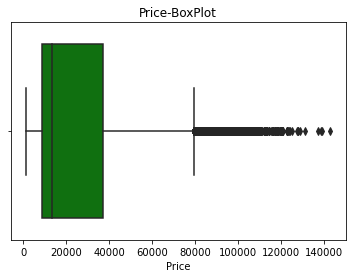

In [14]:
sns.boxplot(data=df, x='Price',color="green")
plt.title('Price-BoxPlot')

Text(0.5, 1.0, 'Distribution of Price')

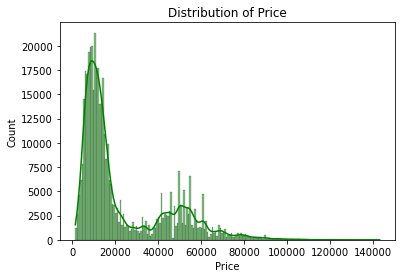

In [15]:
sns.histplot(data=df, x="Price",kde=True,color='green')
plt.title('Distribution of Price')

In [16]:
df["Duration_in_hrs"].describe()

count    445366.000000
mean         12.182491
std           7.299361
min           0.750000
25%           6.500000
50%          11.250000
75%          16.333333
max          43.583333
Name: Duration_in_hrs, dtype: float64

Text(0.5, 1.0, 'Duration-ViolinPlot')

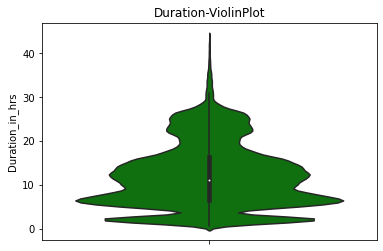

In [17]:
sns.violinplot(data=df, y='Duration_in_hrs',color="green")

plt.title("Duration-ViolinPlot")

In [18]:
df.loc[df['Duration_in_hrs']>40].head(3)

,Date of Journey,Total Stops,Price,Airline,Flight_Code,Class,Source,Destination,Days_left,Journey_day,Dep,Arr,Route,Duration_in_hrs
36912,2023-01-16,2+-sto,30424,Vistara,UK-959,PREMIUMECONOMY,Delhi,Hyderabad,1,Monday,Morning,Early Morning,Delhi-->Hyderabad,41.583333
38208,2023-01-21,2+-sto,20270,Vistara,UK-959,PREMIUMECONOMY,Delhi,Hyderabad,6,Saturday,Morning,Early Morning,Delhi-->Hyderabad,41.583333
38471,2023-01-22,2+-sto,18702,Vistara,UK-959,PREMIUMECONOMY,Delhi,Hyderabad,7,Sunday,Morning,Early Morning,Delhi-->Hyderabad,41.583333


In [19]:
df.groupby(["Route","Class","Total Stops"])['Duration_in_hrs'].agg(['min','mean','max'])


min       mean  \
Route                 Class          Total Stops                         
Ahmedabad-->Bangalore BUSINESS       1-stop        3.666667  14.540577   
                                     2+-sto       13.416667  13.416667   
                      ECONOMY        1-stop        3.666667  12.415107   
                                     2+-sto        7.250000  14.285714   
                                     non-st        2.000000   2.177963   
...                                                     ...        ...   
Mumbai-->Kolkata      ECONOMY        2+-sto        5.500000  18.109231   
                                     non-st        2.333333   2.656190   
                      PREMIUMECONOMY 1-stop        4.750000  12.234848   
                                     2+-sto        7.583333  20.317179   
                                     non-st        2.750000   2.750000   

                                                        max  
Route                 Class          Total Stops             
Ahmedabad-->Bangalore BUSINESS       1-stop       29.750000  
                                     2+-sto       13.416667  
                      ECONOMY        1-stop       42.083333  
                                     2+-sto       28.333333  
                                     non-st        2.500000  
...                                                     ...  
Mumbai-->Kolkata      ECONOMY        2+-sto       35.916667  
                                     non-st        3.083333  
                      PREMIUMECONOMY 1-stop       27.583333  
                                     2+-sto       40.333333  
                                     non-st        2.750000  

[320 rows x 3 columns]

In [20]:
data=df.groupby(["Route"])['Duration_in_hrs'].describe().reset_index()[['Route','75%']]
data.head(3)

,Route,75%
0,Ahmedabad-->Bangalore,15.916667
1,Ahmedabad-->Chennai,18.833333
2,Ahmedabad-->Delhi,15.583333


In [21]:
df_new = df.merge(data,on="Route",how="left")
df_new.head(3)

,Date of Journey,Total Stops,Price,Airline,Flight_Code,Class,Source,Destination,Days_left,Journey_day,Dep,Arr,Route,Duration_in_hrs,75%
0,2023-01-16,non-st,5335,SpiceJet,SG-8169,ECONOMY,Delhi,Mumbai,1,Monday,Night,Late Night,Delhi-->Mumbai,2.083333,14.25
1,2023-01-16,non-st,5899,Indigo,6E-2519,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.333333,14.25
2,2023-01-16,non-st,5801,GO FIRST,G8- 354,ECONOMY,Delhi,Mumbai,1,Monday,Late Night,Early Morning,Delhi-->Mumbai,2.166667,14.25


In [22]:
mask = df_new['Duration_in_hrs']>df_new['75%']
df_new.loc[mask,'Duration_in_hrs'] = df_new['75%']

Text(0.5, 1.0, 'Duration-Boxplot')

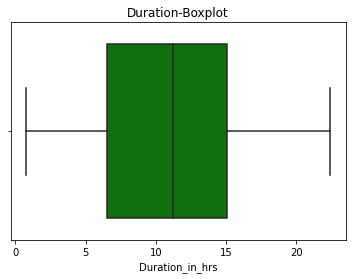

In [23]:
sns.boxplot(data=df_new, x="Duration_in_hrs",color="green")
plt.title('Duration-Boxplot')

In [24]:
# df_new.drop(['Flight_Code','75%'],axis=1,inplace=True)
# df_new.columns

# sns.lineplot(data=df_new, x='Date of Journey', y="Price",hue="Class")
# plt.xticks(rotation=90)
# plt.legend(fontsize=6)
# plt.show()

In [25]:
# df_new["Class"].value_counts().plot(kind="pie",autopct="%1.1f%%",shadow=True)
# plt.legend(fontsize=6,loc=1)
# plt.show()

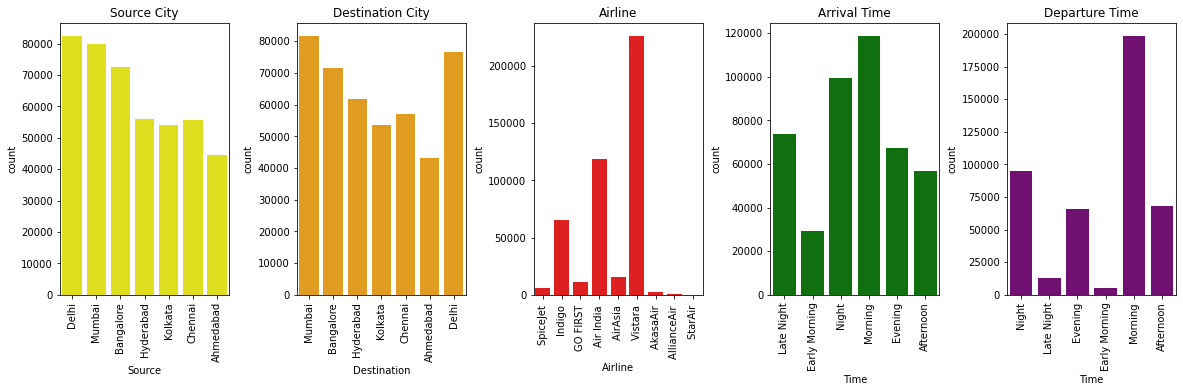

In [26]:
#plotting all plots in same line
fig,ax = plt.subplots(1,5,figsize=(20,5))

#Adjusting the space in betweeen
fig.subplots_adjust(wspace=0.4)

#subplot1- Source
plt.subplot(1,5,1)
sns.countplot(x='Source',data=df_new,color="yellow")
plt.title("Source City")
plt.xticks(rotation=90)

#subplot2 = Destination
plt.subplot(1,5,2)
sns.countplot(x='Destination',data=df_new,color="orange")
plt.title("Destination City")
plt.xticks(rotation=90)

#subplot3 = Airline
plt.subplot(1,5,3)
sns.countplot(x='Airline',data=df_new,color="red")
plt.title("Airline")
plt.xticks(rotation=90)

#subplot4 = Arrival Time
plt.subplot(1,5,4)
sns.countplot(x='Arr',data=df_new,color="green")
plt.title("Arrival Time")
plt.xlabel("Time")
plt.xticks(rotation=90)

#subplot5 = Departure Time
plt.subplot(1,5,5)
sns.countplot(x='Dep',data=df_new,color="purple")
plt.title("Departure Time")
plt.xlabel("Time")
plt.xticks(rotation=90)

plt.show()


In [27]:
df_new["Route"].value_counts().head(3)

Delhi-->Mumbai       19113
Delhi-->Bangalore    17508
Bangalore-->Delhi    17368
Name: Route, dtype: int64

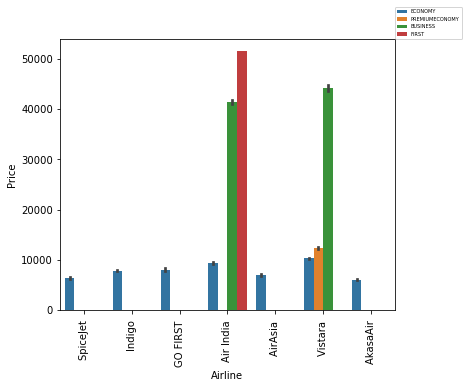

In [28]:
plt.figure(figsize=(6,5))
sns.barplot(data=df_new[df_new["Route"]=="Delhi-->Mumbai"], x="Airline",y="Price",hue="Class")
plt.legend(loc=(1,1),fontsize=5)
plt.xticks(rotation=90)
plt.show()

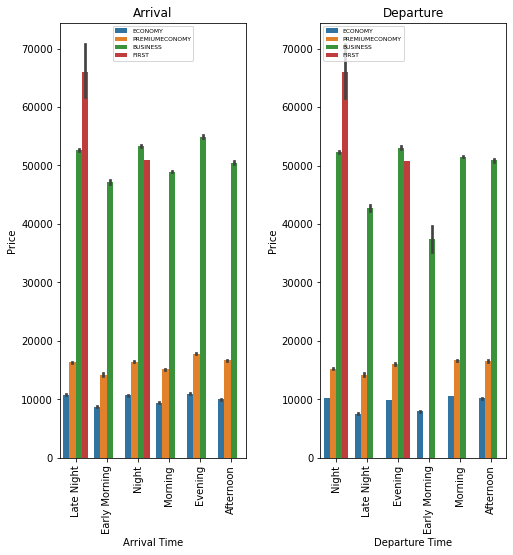

In [29]:
fig,ax = plt.subplots(1,2,figsize=(8,8))
plt.subplots_adjust(wspace=0.4)
sns.barplot(data=df_new,x='Dep',y="Price",hue="Class")
plt.xticks(rotation=90)
plt.xlabel("Departure Time")
plt.title("Departure")
plt.legend(fontsize=6)

plt.subplot(1,2,1)
sns.barplot(data=df_new,x='Arr',y="Price",hue="Class")
plt.xticks(rotation=90)
plt.xlabel("Arrival Time")
plt.title("Arrival")
plt.legend(fontsize=6)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


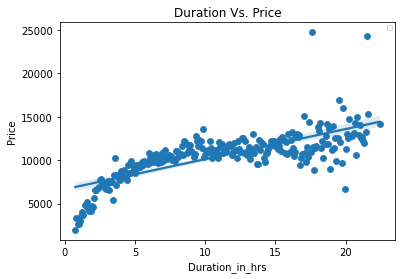

In [30]:
dur = df_new[(df_new["Class"]=="ECONOMY")].groupby(["Duration_in_hrs"])["Price"].mean().reset_index()
dur.head(3)

sns.scatterplot(data=dur, x='Duration_in_hrs',y="Price")
sns.regplot(data=dur, x='Duration_in_hrs',y='Price')
plt.title("Duration Vs. Price")
plt.legend(fontsize=6)
plt.show()

<AxesSubplot:xlabel='Days_left', ylabel='Price'>

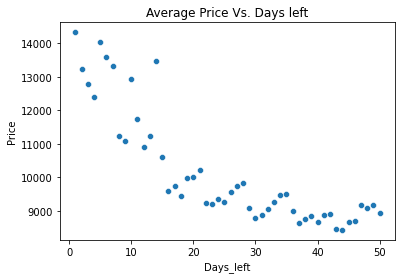

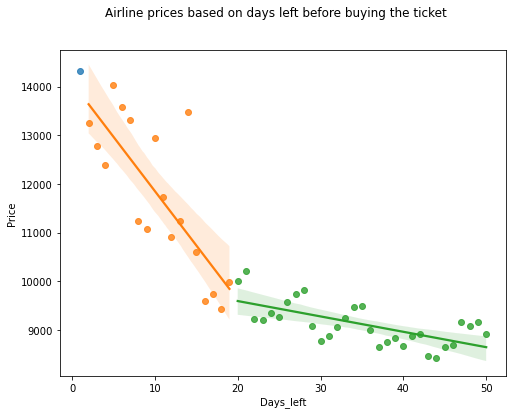

In [31]:
df_days = df_new[(df_new["Class"]=="ECONOMY")].groupby(['Days_left'])['Price'].mean().reset_index()


ax = sns.scatterplot(x="Days_left", y="Price", data=df_days).set_title("Average Price Vs. Days left")

plt.figure(figsize=(8,6)).suptitle('Airline prices based on days left before buying the ticket', fontsize=12)

ax = plt.axes()

sns.regplot(x=df_days.loc[df_days["Days_left"]==1].Days_left, y=df_days.loc[df_days["Days_left"]==1].Price, fit_reg=False, ax=ax)
sns.regplot(x=df_days.loc[(df_days["Days_left"]>1)&(df_days["Days_left"]<20)].Days_left, y=df_days.loc[(df_days["Days_left"]>1)&(df_days["Days_left"]<20)].Price, fit_reg=True, ax=ax)
sns.regplot(x=df_days.loc[df_days["Days_left"]>=20].Days_left, y=df_days.loc[df_days["Days_left"]>=20].Price, fit_reg=True, ax=ax)

In [32]:
counts = df_new['Journey_day'].value_counts()


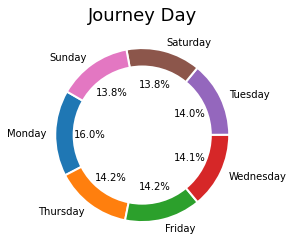

In [33]:

# Create the pie chart
fig, ax = plt.subplots()
pie = ax.pie(counts,labels= counts.index, autopct='%1.1f%%', 
                 wedgeprops={ 'linewidth' : 2, 'edgecolor' : 'white' },
                 startangle=150,labeldistance=1.1)
    
# Add a circle at the center of the chart to create the donut shape
center_circle = plt.Circle((0, 0), 0.8, fc='white')
fig.gca().add_artist(center_circle)

    
plt.title('Journey Day', fontsize=18)

# Show the plot
plt.show()


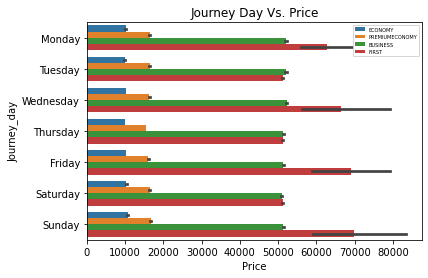

In [34]:
sns.barplot(data=df_new, y="Journey_day", x="Price",hue="Class")
plt.title("Journey Day Vs. Price")
plt.legend(fontsize=5)
plt.show()

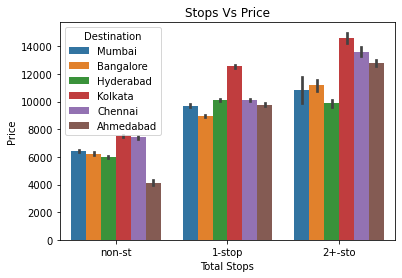

In [35]:
sns.barplot(data=df_new[(df_new["Source"]=="Delhi")&(df_new["Class"]=="ECONOMY")],x="Total Stops",y="Price",hue="Destination")

plt.title("Stops Vs Price")
plt.show()

In [36]:
#Let us make a copy of df_new
df_final = df_new.copy()
df_final.columns

Index(['Date of Journey', 'Total Stops', 'Price', 'Airline', 'Flight_Code',
       'Class', 'Source', 'Destination', 'Days_left', 'Journey_day', 'Dep',
       'Arr', 'Route', 'Duration_in_hrs', '75%'],
      dtype='object')

In [37]:
def preprocessing(df):
    
    #Encode the ordinal variables Total Stops,Class,Journey_day,Dep,Arr
    
    df['Total Stops'] = df['Total Stops'].replace({'non-st':0,'1-stop':1,'2+-sto':2}).astype(int)
    df['Class'] =df['Class'].replace({'ECONOMY':0,'PREMIUMECONOMY':1,'BUSINESS':2,'FIRST':3}).astype(int)
    df['Journey_day'] = df["Journey_day"].map({'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6})
    df['Dep'] = df['Dep'].map({'Early Morning':0,'Morning':1,'Afternoon':2,'Evening':3,'Night':4,'Late Night':5})
    df['Arr'] = df['Arr'].map({'Early Morning':0,'Morning':1,'Afternoon':2,'Evening':3,'Night':4,'Late Night':5})
    
    #Create dummy variables for Airline, Source, Destination
    
    cols = ['Airline','Source','Destination']
    dummies = pd.get_dummies(df[cols],drop_first=True)
    df = pd.concat([df,dummies],axis=1)
    
    df.drop(['Date of Journey','Airline','Source', 'Destination','Route'],axis=1,inplace=True)
    
    return df

In [38]:
df_preprocessed = preprocessing(df_final)
# df_preprocessed.columns()

In [39]:
X = df_preprocessed.drop(['Price', 'Flight_Code'],axis=1)
y = df_preprocessed['Price']

In [40]:
X

,Total Stops,Class,Days_left,Journey_day,Dep,Arr,Duration_in_hrs,75%,Airline_AirAsia,Airline_AkasaAir,...,Source_Delhi,Source_Hyderabad,Source_Kolkata,Source_Mumbai,Destination_Bangalore,Destination_Chennai,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_Mumbai
0,0,0,1,0,4,5,2.083333,14.250000,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,1,0,5,0,2.333333,14.250000,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,1,0,5,0,2.166667,14.250000,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,1,0,3,4,2.083333,14.250000,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,1,0,4,5,2.166667,14.250000,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445361,1,2,50,0,1,3,11.250000,18.833333,0,0,...,0,0,0,0,0,1,0,0,0,0
445362,1,2,50,0,1,4,11.166667,18.833333,0,0,...,0,0,0,0,0,1,0,0,0,0
445363,1,2,50,0,1,4,13.083333,18.833333,0,0,...,0,0,0,0,0,1,0,0,0,0
445364,1,2,50,0,1,3,11.250000,18.833333,0,0,...,0,0,0,0,0,1,0,0,0,0


In [41]:
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1,shuffle=True)
# rs = RobustScaler()
st = StandardScaler()
X_train = st.fit_transform(X_train)
X_test = st.transform(X_test)

In [42]:
# knn = KNeighborsRegressor()

# knn.fit(X_train,y_train)

# #predicting
# y_pred = knn.predict(X_test)

In [43]:
# print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
# print("Mean Squared Error:",mean_squared_error(y_test,y_pred))
# print("R2 Score:",r2_score(y_test,y_pred))

In [44]:
lr = LinearRegression()

lr.fit(X_train,y_train)

#prediction
y_pred = lr.predict(X_test)

#model evaluation
print("R2 Score",r2_score(y_test,y_pred))

R2 Score 0.7707331628821359


In [45]:
dt = DecisionTreeRegressor(random_state=1)

dt.fit(X_train,y_train)

#prediction
y_pred = dt.predict(X_test)

#model evaluation
print("R2 Score",r2_score(y_test,y_pred))

R2 Score 0.9171043911644403


In [46]:
#model building
xg = XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=1)
xg.fit(X_train,y_train)
#prediction
y_pred = xg.predict(X_test)

#model evaluation
print("R2 Score",r2_score(y_test,y_pred))

R2 Score 0.9451796757043363


In [47]:
rf = RandomForestRegressor(n_estimators = 300,random_state=1)

rf.fit(X_train,y_train)

#prediction
y_pred = rf.predict(X_test)

#model evaluation
print("R2 Score",r2_score(y_test,y_pred))

R2 Score 0.9503311641971852


In [48]:
price_data = pd.DataFrame({"Predicted Price":np.rint(rf.predict(X_test)),'Actual Price':y_test}).reset_index(drop=True)
price_data.tail(20)

,Predicted Price,Actual Price
133590,13512.0,13042
133591,10400.0,12178
133592,13925.0,15248
133593,39616.0,39377
133594,37417.0,37417
133595,5259.0,3975
133596,15217.0,14435
133597,13670.0,14034
133598,13976.0,13971
133599,5661.0,5394


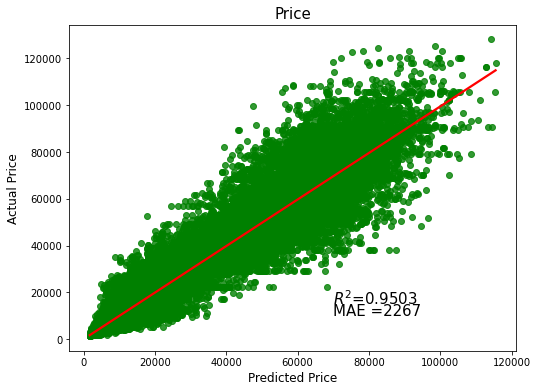

In [49]:
plt.figure(figsize=(8,6))
plt.title("Price",fontsize=15)
plt.ylabel('Test Predicted price',fontsize=12)
plt.xlabel('Test Actual price',fontsize=12)
sns.regplot(data = price_data, x = 'Predicted Price', y = 'Actual Price',scatter_kws={"color": "green"}, line_kws={"color": "red"})

score_r2 = r2_score(y_test, y_pred) 
score_mae = mean_absolute_error(y_test, y_pred)
plt.text(70000,15000,'$ R^{2} $=' + str(round(score_r2, 4)),fontsize=15)
plt.text(70000,10000,'MAE =' + str(round(score_mae)),fontsize=15)
plt.show()

In [50]:
df_preprocessed.columns

Index(['Total Stops', 'Price', 'Flight_Code', 'Class', 'Days_left',
       'Journey_day', 'Dep', 'Arr', 'Duration_in_hrs', '75%',
       'Airline_AirAsia ', 'Airline_AkasaAir ', 'Airline_AllianceAir ',
       'Airline_GO FIRST ', 'Airline_Indigo ', 'Airline_SpiceJet ',
       'Airline_StarAir ', 'Airline_Vistara ', 'Source_Bangalore',
       'Source_Chennai', 'Source_Delhi', 'Source_Hyderabad', 'Source_Kolkata',
       'Source_Mumbai', 'Destination_Bangalore', 'Destination_Chennai',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_Mumbai'],
      dtype='object')

In [51]:
# X1 = df_preprocessed.drop(['Price','Airline_AllianceAir ','Airline_AkasaAir ','Airline_StarAir ','Flight_Code'],axis=1)
# print(X1)
# y1 = df_preprocessed['Price']
# X_train,X_test,y_train,y_test = train_test_split(X1,y1,test_size=0.3,random_state=1,shuffle=True)
# scaler = RobustScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# #model building
# rf1 = RandomForestRegressor(n_estimators = 300,random_state=1)

# rf1.fit(X_train,y_train)

# #prediction
# y_pred = rf1.predict(X_test)

# #model evaluation
# # print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
# # print("Mean Squared Error:",mean_squared_error(y_test,y_pred))
# print("R2 Score",r2_score(y_test,y_pred))

In [53]:
import pickle

#save the model
pickle.dump(rf , open('Airplane_model.pkl', 'wb'))
#save the scaler
pickle.dump(st, open('Scaler.pkl', 'wb'))
# Loading the Saved Model
loaded_model = pickle.load(open('Airplane_model.pkl','rb'))
df_preprocessed.iloc[0].values

array([0, 5335, 'SG-8169', 0, 1, 0, 4, 5, 2.0833333333333335, 14.25, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=object)

In [58]:
y_prediction = loaded_model.predict(st.transform([[0.00000000e+00,0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 4.00000000e+00, 5.00000000e+00, 2.08333333e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]))

y_prediction

array([13597.29666667])

In [12]:
from flask import Flask, request, render_template
from flask_cors import cross_origin
import sklearn
import pickle
import pandas as pd


app = Flask(__name__)
model = pickle.load(open("C:/Users/Anjali Mutyala/Downloads/ML Project/flight-price-prediction-main/c1_flight_rf.pkl", "rb"))


@app.route("/")
@cross_origin()
def home():
    return render_template("home.html")

@app.route("/predict", methods = ["GET", "POST"])
@cross_origin()
def predict():
    if request.method == "POST":

        # Date_of_Journey
        date_dep = request.form["Dep_Time"]
        journey_day = int(pd.to_datetime(date_dep, format="%Y-%m-%dT%H:%M").day)
        journey_month = int(pd.to_datetime(date_dep, format ="%Y-%m-%dT%H:%M").month)
        # print("Journey Date : ",Journey_day, Journey_month)

        # Departure
        dep_hour = int(pd.to_datetime(date_dep, format ="%Y-%m-%dT%H:%M").hour)
        dep_min = int(pd.to_datetime(date_dep, format ="%Y-%m-%dT%H:%M").minute)
        # print("Departure : ",Dep_hour, Dep_min)

        # Arrival
        date_arr = request.form["Arrival_Time"]
        arrival_hour = int(pd.to_datetime(date_arr, format ="%Y-%m-%dT%H:%M").hour)
        arrival_min = int(pd.to_datetime(date_arr, format ="%Y-%m-%dT%H:%M").minute)
        # print("Arrival : ", Arrival_hour, Arrival_min)

        # Duration
        Duration_hour = abs(arrival_hour - dep_hour)
        Duration_mins = abs(arrival_min - dep_min)
        # print("Duration : ", dur_hour, dur_min)

        # Total Stops
        Total_Stops = int(request.form["stops"])
        # print(Total_stops)



        airline=request.form['airline']
        if(airline=='Jet Airways'):
            Airline_AirIndia = 0
            Airline_GoAir = 0
            Airline_IndiGo = 0
            Airline_JetAirways = 1
            Airline_MultipleCarriers = 0
            Airline_SpiceJet = 0
            Airline_Vistara = 0
            Airline_Other = 0

        elif (airline=='IndiGo'):
            Airline_AirIndia = 0
            Airline_GoAir = 0
            Airline_IndiGo = 1
            Airline_JetAirways = 0
            Airline_MultipleCarriers = 0
            Airline_SpiceJet = 0
            Airline_Vistara = 0
            Airline_Other = 0

        elif (airline=='Air India'):
            Airline_AirIndia = 1
            Airline_GoAir = 0
            Airline_IndiGo = 0
            Airline_JetAirways = 0
            Airline_MultipleCarriers = 0
            Airline_SpiceJet = 0
            Airline_Vistara = 0
            Airline_Other = 0
            
        elif (airline=='Multiple carriers'):
            Airline_AirIndia = 0
            Airline_GoAir = 0
            Airline_IndiGo = 0
            Airline_JetAirways = 0
            Airline_MultipleCarriers = 1
            Airline_SpiceJet = 0
            Airline_Vistara = 0
            Airline_Other = 0
            
        elif (airline=='SpiceJet'):
            Airline_AirIndia = 0
            Airline_GoAir = 0
            Airline_IndiGo = 0
            Airline_JetAirways = 0
            Airline_MultipleCarriers = 0
            Airline_SpiceJet = 1
            Airline_Vistara = 0
            Airline_Other = 0
            
        elif (airline=='Vistara'):
            Airline_AirIndia = 0
            Airline_GoAir = 0
            Airline_IndiGo = 0
            Airline_JetAirways = 0
            Airline_MultipleCarriers = 0
            Airline_SpiceJet = 0
            Airline_Vistara = 1
            Airline_Other = 0

        elif (airline=='GoAir'):
            Airline_AirIndia = 0
            Airline_GoAir = 1
            Airline_IndiGo = 0
            Airline_JetAirways = 0
            Airline_MultipleCarriers = 0
            Airline_SpiceJet = 0
            Airline_Vistara = 0
            Airline_Other = 0

        else:
            Airline_AirIndia = 0
            Airline_GoAir = 0
            Airline_IndiGo = 0
            Airline_JetAirways = 0
            Airline_MultipleCarriers = 0
            Airline_SpiceJet = 0
            Airline_Vistara = 0
            Airline_Other = 1


        Source = request.form["Source"]
        if (Source == 'Delhi'):
            Source_Delhi = 1
            Source_Kolkata = 0
            Source_Mumbai = 0
            Source_Chennai = 0

        elif (Source == 'Kolkata'):
            Source_Delhi = 0
            Source_Kolkata = 1
            Source_Mumbai = 0
            Source_Chennai = 0

        elif (Source == 'Mumbai'):
            Source_Delhi = 0
            Source_Kolkata = 0
            Source_Mumbai = 1
            Source_Chennai = 0

        elif (Source == 'Chennai'):
            Source_Delhi = 0
            Source_Kolkata = 0
            Source_Mumbai = 0
            Source_Chennai = 1

        else:
            Source_Delhi = 0
            Source_Kolkata = 0
            Source_Mumbai = 0
            Source_Chennai = 0



        Source = request.form["Destination"]
        if (Source == 'Cochin'):
            Destination_Cochin = 1
            Destination_Delhi = 0
            Destination_Hyderabad = 0
            Destination_Kolkata = 0
        
        elif (Source == 'Delhi'):
            Destination_Cochin = 0
            Destination_Delhi = 1
            Destination_Hyderabad = 0
            Destination_Kolkata = 0

        elif (Source == 'Hyderabad'):
            Destination_Cochin = 0
            Destination_Delhi = 0
            Destination_Hyderabad = 1
            Destination_Kolkata = 0

        elif (Source == 'Kolkata'):
            Destination_Cochin = 0
            Destination_Delhi = 0
            Destination_Hyderabad = 0
            Destination_Kolkata = 1

        else:
            Destination_Cochin = 0
            Destination_Delhi = 0
            Destination_Hyderabad = 0
            Destination_Kolkata = 0


        prediction=model.predict([[
            Total_Stops,
            journey_day,
            journey_month,
            dep_hour,
            dep_min,
            arrival_hour,
            arrival_min,
            Duration_hour,
            Duration_mins,
            Airline_AirIndia,
            Airline_GoAir,
            Airline_IndiGo,
            Airline_JetAirways,
            Airline_MultipleCarriers,
            Airline_Other,
            Airline_SpiceJet,
            Airline_Vistara,
            Source_Chennai,
            Source_Kolkata,
            Source_Mumbai,
            Destination_Cochin,
            Destination_Delhi,
            Destination_Hyderabad,
            Destination_Kolkata,
        ]])

        output=round(prediction[0],2)

        return render_template('home.html',prediction_text="Your Flight price is Rs. {}".format(output))


    return render_template("home.html")




if __name__ == "__main__":
    app.run(debug=True)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with watchdog (windowsapi)


SystemExit: 1

In [5]:
!pip3 install Flask-Cors